<a href="https://colab.research.google.com/github/kridtapon/CMF-OBV-Williams_R-Proxy/blob/main/CMF%2BOBV%2BWilliams_R_Proxy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.4 MB/s eta 0:00:00


In [1]:
pip install --upgrade yfinance

In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate Chaikin Money Flow (CMF)
def calculate_cmf(df, period=20):
    mfv = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    mfv = mfv * df['Volume']
    cmf = mfv.rolling(window=period).sum() / df['Volume'].rolling(window=period).sum()
    return cmf

# Function to calculate On-Balance Volume (OBV)
def calculate_obv(df):
    obv = (np.sign(df['Close'].diff()) * df['Volume']).cumsum()
    return obv

# Function to calculate Williams %R
def calculate_williams_r(df, period=14):
    highest_high = df['High'].rolling(window=period).max()
    lowest_low = df['Low'].rolling(window=period).min()
    williams_r = -100 * (highest_high - df['Close']) / (highest_high - lowest_low)
    return williams_r

# Define the stock symbol and time period
symbol = 'NVDA'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate Chaikin Money Flow (CMF)
df['CMF'] = calculate_cmf(df)

# Calculate On-Balance Volume (OBV)
df['OBV'] = calculate_obv(df)

# Calculate Williams %R
df['Williams_R'] = calculate_williams_r(df)

# Normalize the indicators
df['Normalized_CMF'] = (df['CMF'] - df['CMF'].min()) / (df['CMF'].max() - df['CMF'].min())  # Normalize CMF to 0-1 range
df['Normalized_OBV'] = (df['OBV'] - df['OBV'].min()) / (df['OBV'].max() - df['OBV'].min())  # Normalize OBV to 0-1 range
df['Normalized_Williams_R'] = (df['Williams_R'] + 100) / 200  # Normalize Williams %R to 0-1 range

# Combine indicators to form a composite proxy (simple sum in this case, with weights)
df['Composite_Proxy'] = 0.4 * df['Normalized_CMF'] + 0.3 * df['Normalized_OBV'] + 0.3 * df['Normalized_Williams_R']

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Define Entry and Exit signals based on Composite Proxy
df['Entry'] = df['Composite_Proxy'] > 0.4  # Buy when composite proxy > 0.4
df['Exit'] = df['Composite_Proxy'] < 0.2  # Sell when composite proxy < 0.2

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001,
    freq='D'
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           2608065.37065
Total Return [%]                      2508.065371
Benchmark Return [%]                  2148.392694
Max Gross Exposure [%]                      100.0
Total Fees Paid                        758.924387
Max Drawdown [%]                        61.375084
Max Drawdown Duration           360 days 00:00:00
Total Trades                                    2
Total Closed Trades                             1
Total Open Trades                               1
Open Trade PnL                      2278553.55638
Win Rate [%]                                100.0
Best Trade [%]                         229.741326
Worst Trade [%]                        229.741326
Avg Winning Trade [%]                  229.741326
Avg Losing Trade [%]                          NaN


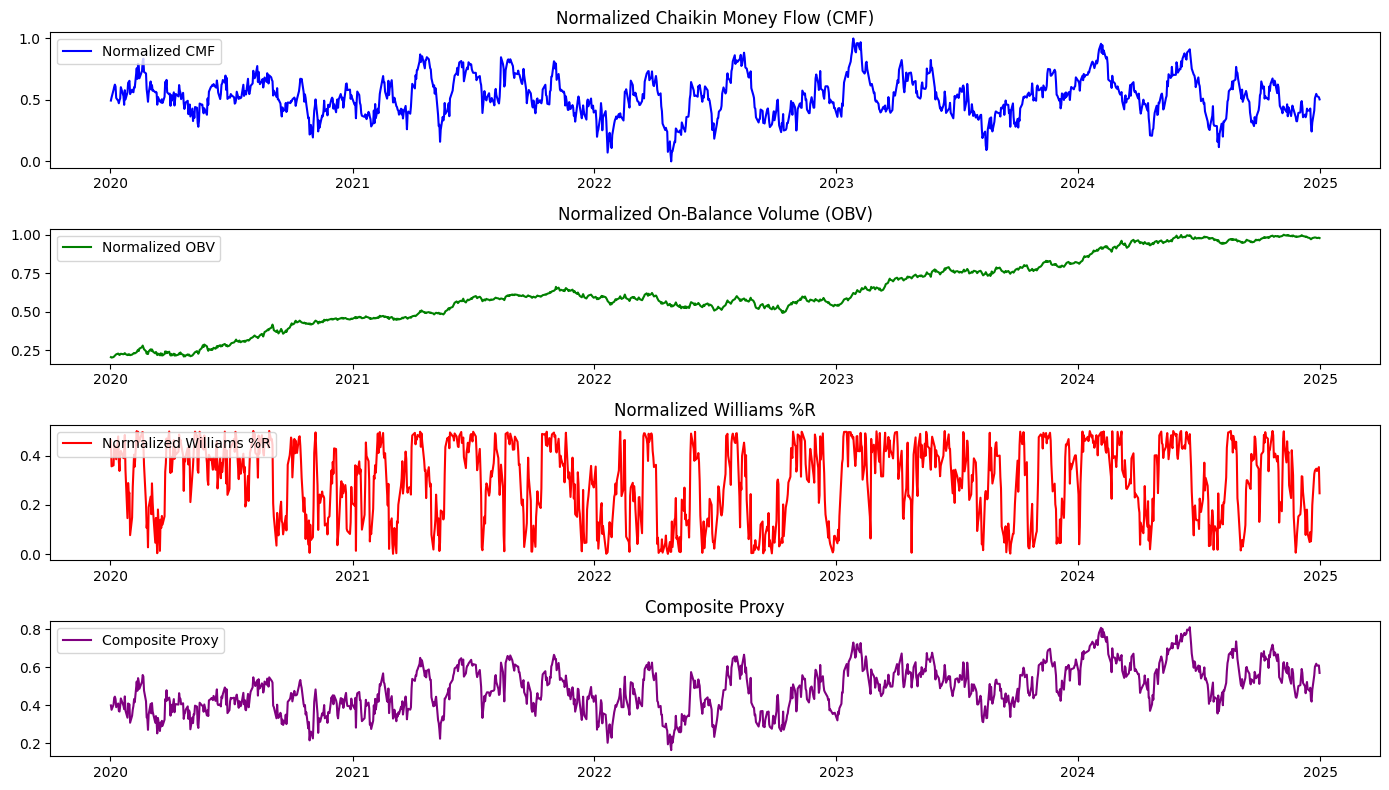

In [14]:
import matplotlib.pyplot as plt

# Plot Normalized Indicators and Composite Proxy
plt.figure(figsize=(14, 8))

# Plot Normalized CMF
plt.subplot(4, 1, 1)
plt.plot(df.index, df['Normalized_CMF'], label='Normalized CMF', color='blue')
plt.title('Normalized Chaikin Money Flow (CMF)')
plt.legend(loc='upper left')

# Plot Normalized OBV
plt.subplot(4, 1, 2)
plt.plot(df.index, df['Normalized_OBV'], label='Normalized OBV', color='green')
plt.title('Normalized On-Balance Volume (OBV)')
plt.legend(loc='upper left')

# Plot Normalized Williams %R
plt.subplot(4, 1, 3)
plt.plot(df.index, df['Normalized_Williams_R'], label='Normalized Williams %R', color='red')
plt.title('Normalized Williams %R')
plt.legend(loc='upper left')

# Plot Composite Proxy
plt.subplot(4, 1, 4)
plt.plot(df.index, df['Composite_Proxy'], label='Composite Proxy', color='purple')
plt.title('Composite Proxy')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed


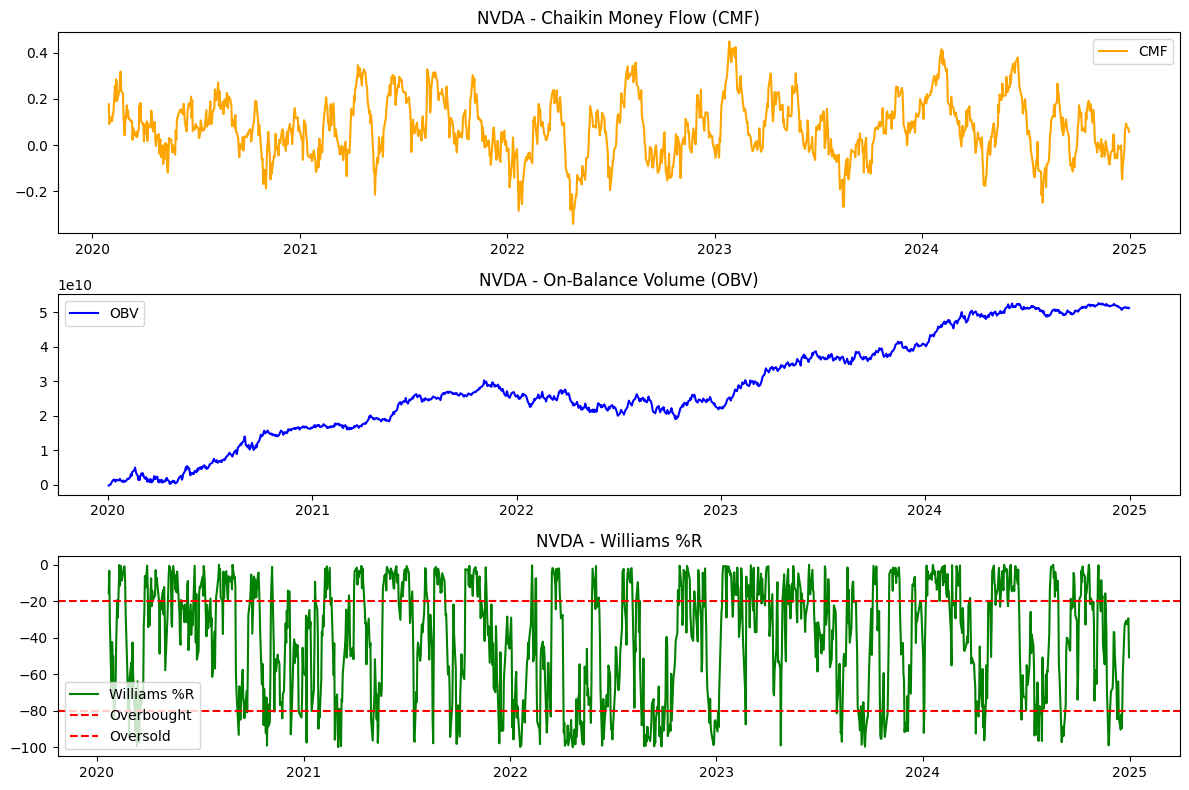

In [16]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Function to calculate Chaikin Money Flow (CMF)
def calculate_cmf(df, period=20):
    mfv = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    mfv = mfv * df['Volume']
    cmf = mfv.rolling(window=period).sum() / df['Volume'].rolling(window=period).sum()
    return cmf

# Function to calculate On-Balance Volume (OBV)
def calculate_obv(df):
    obv = (np.sign(df['Close'].diff()) * df['Volume']).cumsum()
    return obv

# Function to calculate Williams %R
def calculate_williams_r(df, period=14):
    highest_high = df['High'].rolling(window=period).max()
    lowest_low = df['Low'].rolling(window=period).min()
    williams_r = -100 * (highest_high - df['Close']) / (highest_high - lowest_low)
    return williams_r

# Define the stock symbol and time period
symbol = 'NVDA'
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate indicators
df['CMF'] = calculate_cmf(df)
df['OBV'] = calculate_obv(df)
df['Williams_R'] = calculate_williams_r(df)

# Plot the indicators
plt.figure(figsize=(12, 8))

# Plot Chaikin Money Flow (CMF)
plt.subplot(3, 1, 1)
plt.plot(df.index, df['CMF'], label='CMF', color='orange')
plt.title(f'{symbol} - Chaikin Money Flow (CMF)')
plt.legend(loc='best')

# Plot On-Balance Volume (OBV)
plt.subplot(3, 1, 2)
plt.plot(df.index, df['OBV'], label='OBV', color='blue')
plt.title(f'{symbol} - On-Balance Volume (OBV)')
plt.legend(loc='best')

# Plot Williams %R
plt.subplot(3, 1, 3)
plt.plot(df.index, df['Williams_R'], label='Williams %R', color='green')
plt.axhline(y=-20, color='r', linestyle='--', label='Overbought')
plt.axhline(y=-80, color='r', linestyle='--', label='Oversold')
plt.title(f'{symbol} - Williams %R')
plt.legend(loc='best')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()
